In [26]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time

In [27]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

### Paths

In [28]:
celeba_path = Path('../../Dataset/img_celeba_cropped/')
celeba_identity_path = Path('../../Dataset/celeb_identity_processed.txt')

precalculated_pairs_path = Path('../../Dataset/pairs_precalculated.csv')

### Hyperparameters

In [29]:
pair_count = 50

train_size = 0.7

network_input_shape = (224, 224, 3)

batch_size = 16
lr = 1e-6

### a) Creating pairs

In [30]:
df_identity = pd.read_csv(
    celeba_identity_path,
    sep=",",
    names=["image", "identity"],
    header=0,
    dtype=str
)

In [31]:
def create_n_pairs(df_identity, n):
    pairs = []

    for pair in range(n):
        anchor_id = df_identity['identity'].sample(1, replace=True).to_string(index=False)

        keepGoing = True
        while (keepGoing):
            anchor, positive = df_identity.loc[df_identity['identity'] == anchor_id]['image'].sample(2, replace=True)
            keepGoing = (anchor == positive)

        negative = df_identity.loc[df_identity['identity'] != anchor_id]['image'].sample(1, replace=True).to_string(index=False)

        anchor = str(celeba_path) + '/' + anchor
        positive = str(celeba_path) + '/' + positive
        negative = str(celeba_path) + '/' + negative

        pairs.append([anchor, positive, 1])
        pairs.append([anchor, negative, 0])

    return pd.DataFrame(pairs, columns=['left', 'right', 'label'])

In [32]:
pairs = create_n_pairs(df_identity, pair_count)
pairs.head()

,left,right,label
0,../../Dataset/img_celeba_cropped/165265.jpg,../../Dataset/img_celeba_cropped/167377.jpg,1
1,../../Dataset/img_celeba_cropped/165265.jpg,../../Dataset/img_celeba_cropped/031498.jpg,0
2,../../Dataset/img_celeba_cropped/094231.jpg,../../Dataset/img_celeba_cropped/121083.jpg,1
3,../../Dataset/img_celeba_cropped/094231.jpg,../../Dataset/img_celeba_cropped/185587.jpg,0
4,../../Dataset/img_celeba_cropped/093402.jpg,../../Dataset/img_celeba_cropped/139624.jpg,1


In [33]:
pairs.shape

(100, 3)

### b) Loading precalculated pairs from csv

In [34]:
# pairs = pd.read_csv(precalculated_pairs_path, sep=';')
# pairs = str(celeba_path) + '/' + triplets

# pairs.head()

In [35]:
# pairs = pairs[:pair_count]
# pairs.shape

### Visualize triplets

In [36]:
def visualize_pairs(pairs):
    def show(ax, path):
        img = cv2.imread(path)

        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(5, 15))

    axs = fig.subplots(8, 2)
    for i in range(8):
        show(axs[i, 0], pairs.iloc[i][0])
        show(axs[i, 1], pairs.iloc[i][1])

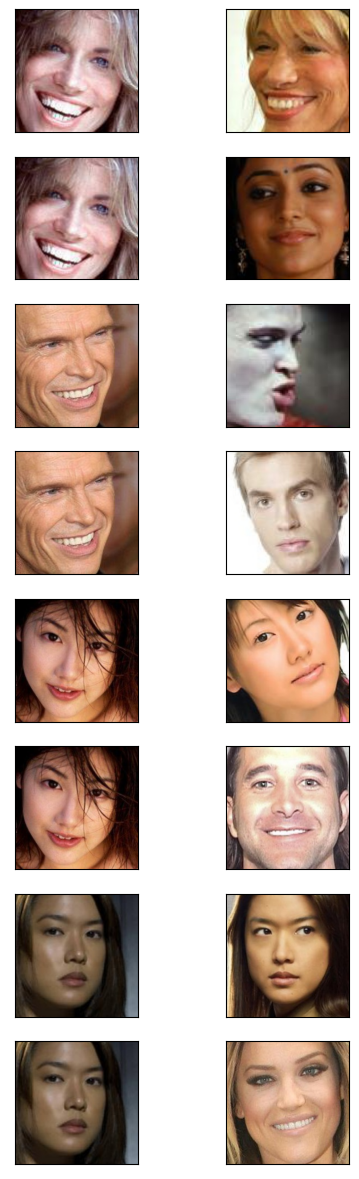

In [37]:
visualize_pairs(pairs)

### TF Pipeline

In [38]:
def preprocessing(left, right, label):
    return (
        (convert_to_img(left), convert_to_img(right)),
        label_preprocessing(label),
    )


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = resnet50.preprocess_input(img)
    return img


def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [39]:
features = tf.data.Dataset.from_tensor_slices(
    (pairs['left'].values,
     pairs['right'].values,
     pairs['label'].values)
)

dataset = features.map(preprocessing)

### Test val splits

In [40]:
train_dataset = dataset.take(round(pairs.shape[0] * train_size))
val_dataset = dataset.skip(round(pairs.shape[0] * train_size))

### Performance optimization

In [41]:
train_dataset = train_dataset \
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE) \
        .prefetch(buffer_size=tf.data.AUTOTUNE) \
        .cache()

val_dataset = val_dataset \
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE) \
        .prefetch(buffer_size=tf.data.AUTOTUNE) \
        .cache()

# Models

### Resnet 50 embedding

In [42]:
def resnet_embedding():
    input = layers.Input(shape=network_input_shape)

    base_cnn = resnet50.ResNet50(
        input_tensor=input,
        include_top=False,
        input_shape=network_input_shape,
        weights='imagenet'
    )

    for layer in base_cnn.layers[0:-3]:
        layer.trainable = False

    model = layers.Flatten()(base_cnn.output)

    model = layers.Dropout(0.4)(model)
    model = layers.Dense(512, activation="leaky_relu")(model)

    model = layers.Dense(512)(model)

    return Model(input, outputs=model, name='resnet50')

In [43]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x-y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [54]:
embedding = resnet_embedding()

left_input = layers.Input(shape=network_input_shape, name="left_input")
right_input = layers.Input(shape=network_input_shape, name="right_input")

left_tower = embedding(left_input)
right_tower = embedding(right_input)

merge_layer = layers.Subtract(name="lambda_layer")([left_tower,right_tower])

outer_1 = layers.Dense(256, activation="leaky_relu")(merge_layer)

output = layers.Dense(1, activation="sigmoid")(outer_1)

model = Model([left_input, right_input], output, name="siamese_lambda_network")

In [55]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
model.summary()

Model: "siamese_lambda_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 512)          75231104    ['left_input[0][0]',             
                                                                  'right_inpu

In [56]:
# plot_model(model, show_shapes=True)

### Callbacks

In [57]:
tensorboard = TensorBoard(
    log_dir=f"logs/{model.name}_{time.strftime('run_%Y_%m_%d-%H_%M_%S')}",
    # histogram_freq=1,
    # embeddings_freq=1,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

lr_scheduler_reduce = ReduceLROnPlateau(factor=0.5, patience=5)

In [58]:
callbacks_list = [
    early_stopping,
    lr_scheduler_reduce,
]

In [59]:
model_fit = model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=callbacks_list,
    epochs=10,
)

Epoch 1/10
5/5 [==============================] - 59s 9s/step - loss: 1.3932 - accuracy: 0.5143 - val_loss: 1.3881 - val_accuracy: 0.4000 - lr: 1.0000e-06
Epoch 2/10
5/5 [==============================] - 37s 8s/step - loss: 1.3098 - accuracy: 0.4714 - val_loss: 1.3597 - val_accuracy: 0.4000 - lr: 1.0000e-06
Epoch 3/10
5/5 [==============================] - 39s 8s/step - loss: 1.3885 - accuracy: 0.4571 - val_loss: 1.3325 - val_accuracy: 0.4333 - lr: 1.0000e-06
Epoch 4/10
5/5 [==============================] - 53s 12s/step - loss: 1.3478 - accuracy: 0.4571 - val_loss: 1.3091 - val_accuracy: 0.4333 - lr: 1.0000e-06
Epoch 5/10
5/5 [==============================] - 21s 5s/step - loss: 1.3452 - accuracy: 0.5143 - val_loss: 1.2900 - val_accuracy: 0.4000 - lr: 1.0000e-06
Epoch 6/10
5/5 [==============================] - 21s 5s/step - loss: 0.8759 - accuracy: 0.6000 - val_loss: 1.2745 - val_accuracy: 0.4333 - lr: 1.0000e-06
Epoch 7/10
5/5 [==============================] - 34s 8s/step - loss:

### Save model

In [60]:
# save_path = 'saved_models'

#### Save whole model

In [61]:
# model_version = f'{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

# model_path = f'{save_path}/{model_version}'
# model.save(model_path)
# model.save_weights("model_path")

#### Saving just the embedding for predictions

In [62]:
# model_version = f'embedding-{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

# model_path = f'{save_path}/{model_version}'
# embedding.save(model_path, include_optimizer=False)
# embedding.save_weights("model_path")

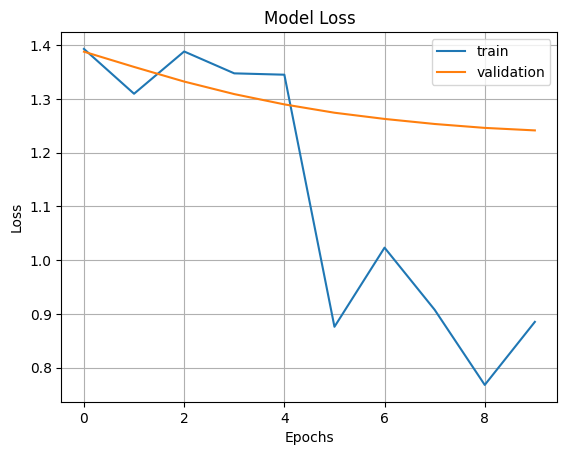

In [63]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

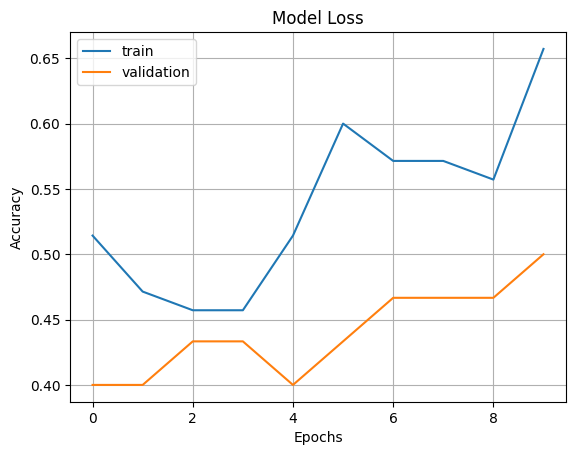

In [70]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

### Tensorboard

In [64]:
# %load_ext tensorboard
# %tensorboard --logdir=logs

In [65]:
pairs = create_n_pairs(df_identity, 50)

In [66]:
pairs.head(6)

,left,right,label
0,../../Dataset/img_celeba_cropped/198121.jpg,../../Dataset/img_celeba_cropped/196238.jpg,1
1,../../Dataset/img_celeba_cropped/198121.jpg,../../Dataset/img_celeba_cropped/137192.jpg,0
2,../../Dataset/img_celeba_cropped/192772.jpg,../../Dataset/img_celeba_cropped/186855.jpg,1
3,../../Dataset/img_celeba_cropped/192772.jpg,../../Dataset/img_celeba_cropped/187078.jpg,0
4,../../Dataset/img_celeba_cropped/068324.jpg,../../Dataset/img_celeba_cropped/050117.jpg,1
5,../../Dataset/img_celeba_cropped/068324.jpg,../../Dataset/img_celeba_cropped/053106.jpg,0


In [63]:
def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [64]:
test_ds_left = create_singular_dataset(pairs['left'])
test_ds_right = create_singular_dataset(pairs['right'])
test_labels = pairs['label']

In [65]:
left_image_feature_vectors = embedding.predict(test_ds_left)
right_image_feature_vectors = embedding.predict(test_ds_right)

7/7 [==============================] - 9s 1s/step


In [67]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

In [68]:
positive_distances = euclidean_distance((positive_left_image_feature_vectors, positive_right_image_feature_vectors)).numpy().flatten()
positive_mean = pd.Series(positive_distances).mean()
pd.Series(positive_distances).describe()

count    50.000000
mean     39.042248
std       3.375288
min      31.251556
25%      37.561728
50%      39.095072
75%      41.244635
max      47.203369
dtype: float64

In [69]:
negative_distances = euclidean_distance((negative_left_image_feature_vectors, negative_right_image_feature_vectors)).numpy().flatten()
negative_mean = pd.Series(negative_distances).mean()
pd.Series(negative_distances).describe()

count    50.000000
mean     39.985947
std       2.844908
min      33.713947
25%      37.806639
50%      39.499702
75%      41.596614
max      47.601696
dtype: float64

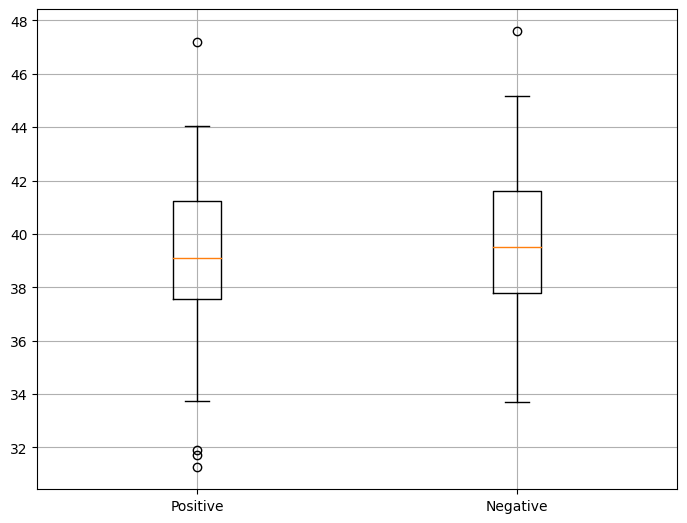

In [70]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [73]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred.flatten() < cutoff
    return np.mean(pred == y_true), pred

In [74]:
y_pred = np.linalg.norm(left_image_feature_vectors-right_image_feature_vectors, axis=1)
cutoff = (positive_mean + negative_mean)/2

In [75]:
test_accuracy, y_pred = compute_accuracy(test_labels, y_pred, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

Accuracy: 52.00%


<AxesSubplot: >

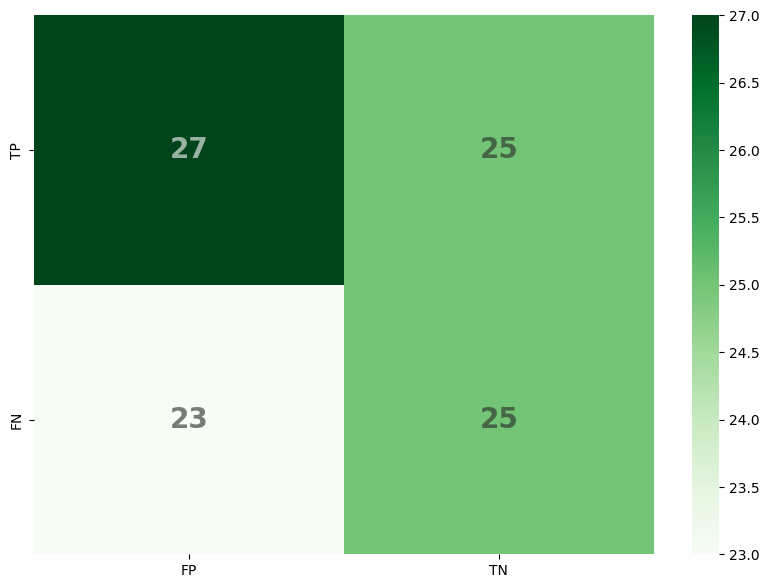

In [76]:
c_matrix = confusion_matrix(y_pred, test_labels, labels=[1, 0])
c_matrix_df = pd.DataFrame(c_matrix, index=["TP", "FN"], columns=["FP", "TN"])
plt.figure(figsize=(10, 7))
sn.heatmap(c_matrix_df, cmap="Greens", annot=True,
           annot_kws={'fontsize': 20, 'fontweight': 'bold', 'alpha': 0.6},
           fmt='g')

In [77]:
report = classification_report(y_pred, test_labels)
print(report)

              precision    recall  f1-score   support

       False       0.50      0.52      0.51        48
        True       0.54      0.52      0.53        52

    accuracy                           0.52       100
   macro avg       0.52      0.52      0.52       100
weighted avg       0.52      0.52      0.52       100



In [80]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([cv2.cvtColor(cv2.imread(pairs["left"].iloc[i]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(pairs["right"].iloc[i]), cv2.COLOR_BGR2RGB)], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels["label"].iloc[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [79]:
visualize(X_val, Y_val_label, to_show=9, num_col=3, predictions=predictions, test=True)

NameError: name 'X_val' is not defined